In [1]:
#===================================
# 1. Download data
#===================================
from download_helper import DownloadMTBLS2639
file_names = DownloadMTBLS2639([3])

In [2]:
# You can set your own libraries search path by adding M2AIA_PATH to your system environment variables
#  - For installed versions of M2aia point to the /path/to/m2aia/installation/bin directory
#  - For compiled versions of M2aia point to the /path/to/m2aia/build/MITK-build/lib directory

# import os
# os.environ["M2AIA_PATH"] = "/home/jtfc/HS/M2aia/m2aia-dev/m2aia-release/MITK-build/lib/"

In [3]:
import pathlib
import seaborn
import umap
import torch

import numpy as np
import m2aia as m2
import matplotlib.pyplot as plt 

from torch.utils.data import DataLoader, SubsetRandomSampler
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim import Adam

from sklearn import cluster
from scipy import signal
from torchvision import transforms

from SimCLR.code.models import CLR, ContrastiveLoss
from Example_V_Helpers import gaussian_noise, AugmentedDataset


/home/jtfc/HS/M2aia/Sources/pym2aia-examples/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Clustering Parameters
n_clusters = 10
n_neighbors = 10

# Network Parameters
# model input dimension for height and width of the input images
target_input_size = 124 
epochs = 50
batch_size = 64

In [5]:
#===================================
# 1.1 Load image handles
#===================================
image_handles = []
for f in file_names:
    I = m2.ImzMLReader(f,
                       pooling=m2.m2PoolingMaximum,
                       normalization=m2.m2NormalizationTIC)
    image_handles.append(I)
    print(I.GetShape())
max_dim = np.max(I.GetShape())

[Fri Nov 10 09:34:08 2023 
35.135] [imzML]: data/150505_ew_section3_pos.imzML
	[pixel size (mm)]: 0.025000x0.025000x0.010000
	[image dimension]: 224x169x1
	[num spectra]: 28278
	[spec. type]: ContinuousProfile
	[mass range]: 99.792458 to 1285.640137 with #29693 measurements
	[normalization]: TIC
[224 169   1]
MaximumDimension 224


In [6]:
#===================================
# 1.1 Pick peaks (mean spectrum)
#===================================
mean = I.GetMeanSpectrum()
min_indices = signal.argrelmin(mean,order=50)[0]
xs = I.GetXAxis()
peaks = signal.find_peaks(mean, height=np.median(mean)*3.5)
centroids = xs[peaks[0]].tolist()
print("Number of centroids", len(centroids))

Number of centroids 148


In [7]:
#===================================
# 1.2 Initialize the ion image Dataset
#===================================
transform_rm_outlies_center_crop_resize = transforms.Compose([
                                          transforms.Lambda(lambda x : torch.Tensor(np.clip(x / np.quantile(x,0.999),0,1))),
                                          transforms.CenterCrop(max_dim),
                                          transforms.Resize(target_input_size)])

dataset = m2.IonImageDataset(image_handles, 
                            centroids=centroids, 
                            tolerance=75, 
                            tolerance_type='ppm', 
                            buffer_type='memory', 
                            transforms=transform_rm_outlies_center_crop_resize)

In [8]:
#===================================
# 1.3 Initialize the augmented ion image 
# Dataset which is used during training
#===================================
# Using: from Example_V_Helpers import gaussian_noise, AugmentedDataset
# Dataset returns two augmentations of the same ion image
blur_kernel_size = 9
augmentations = transforms.Compose([transforms.Lambda(lambda x: torch.tensor(x, dtype=torch.float32)),
                                    transforms.GaussianBlur(blur_kernel_size, sigma=(0.01, 0.75)), 
                                    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.2), 
                                    transforms.Lambda(gaussian_noise)])
aug_dataset = AugmentedDataset(dataset, augmentations)

In [9]:
#===================================
# 2 Initializing the SimCLR model
#===================================
m = CLR()
m = m.cuda()

# for reproducibility
models_root = pathlib.Path("models")
models_root.mkdir(exist_ok=True)
model_path = models_root.joinpath("Example_V_0.model")

if model_path.exists():
    state_dict = torch.load(str(model_path))
    m.load_state_dict(state_dict)
else:
    torch.save(m.state_dict(), str(model_path))
    

Loaded pretrained weights for efficientnet-b0


In [10]:
#===================================
# 2.1 Predict embeddings of the images
# using the pre-finetuned model
#===================================

m.eval()
A = None
for ionImage in dataset:
    # Dataset returns item of form [C,H,W]
    # Network requires items of form [N,C,H,W]
    _, embedding = m(torch.tensor(ionImage[None,...]).cuda())
    embedding = embedding.cpu().detach().numpy()
    if A is None:
        A = embedding
    else:
        A = np.concatenate([A, embedding])

/home/jtfc/HS/M2aia/Sources/pym2aia-examples/.venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/tmp/ipykernel_23247/125580808.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  _, embedd

/home/jtfc/HS/M2aia/Sources/pym2aia-examples/.venv/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/jtfc/HS/M2aia/Sources/pym2aia-examples/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jtfc/HS/M2aia/Sources/pym2aia-examples/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jtfc/HS/M2aia/Sources/pym2aia-examples/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: F

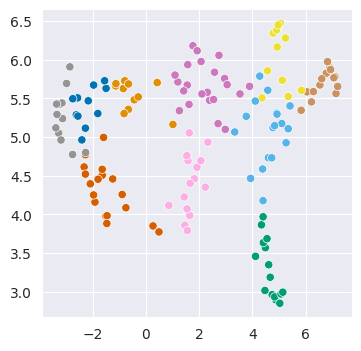

In [11]:
#===================================
# 2.2 Cluster the results using SpectralCustering
#===================================
predictor =  cluster.SpectralClustering(random_state=42,
                                   n_clusters=n_clusters, 
                                   n_neighbors = n_neighbors,
                                   affinity = 'nearest_neighbors', 
                                   assign_labels='discretize')
clusteredA = predictor.fit_predict(A)

#===================================
# 2.3 Use UMAP embeddings
#===================================
transformer = umap.UMAP(random_state=65)
transformedA = transformer.fit_transform(A)

seaborn.set_style('darkgrid')
plt.figure(figsize=(4,4))
fig = seaborn.scatterplot(x=transformedA[:,0], y=transformedA[:,1],hue=clusteredA, legend=False, palette="colorblind")


# plt.savefig(f"{target_path}/FigS81_pre.eps", dpi=350)
# plt.savefig(f"{target_path}/FigS81_pre.tif", dpi=350)
# plt.savefig(f"{target_path}/FigS81_pre.png", dpi=350)

In [12]:
#===================================
# 3 Load trained model parameters
#===================================
models_root = pathlib.Path("models")
models_root.mkdir(exist_ok=True)
model_path = models_root.joinpath("Example_V_1.model")

if model_path.exists():
    state_dict = torch.load(str(model_path))
    m.load_state_dict(state_dict)
else:
#===================================
# 3 Start finetuning and save model
#===================================

    loss = ContrastiveLoss(batch_size)
    loss = loss.cuda()

    optim = Adam(m.parameters())
    scheduler = CosineAnnealingLR(optim, epochs)

    dataloader = DataLoader(aug_dataset,
                            batch_size = batch_size, 
                            sampler = SubsetRandomSampler(list(range(len(aug_dataset)))),
                            pin_memory = True,
                            drop_last = True)

    m.train()
    ## main fit steps
    total_losses = []
    for epoch in range(epochs):
        epoch_losses = []
        for i, [X, Y] in enumerate(dataloader):
            X = X.cuda(non_blocking=True)
            Y = Y.cuda(non_blocking=True)
            _, proj_X = m(X)
            _, proj_Y = m(Y)
            loss_value = loss(proj_X, proj_Y)
            epoch_losses.append(loss_value)
            
            # backward
            optim.zero_grad()
            loss_value.backward()
            optim.step()

        # update lr
        scheduler.step()
        losses_np = torch.tensor(epoch_losses).cpu().numpy()
        print('epoch {} loss: {}'.format(epoch, np.mean(losses_np)))
    
    torch.save(m.state_dict(), str(model_path))

In [13]:
#===================================
# 3.1 Predict embeddings of the images
# using the finetuned model
#===================================

m.eval()
hatA = None
for ionImage in dataset:
    # Dataset returns item of form [C,H,W]
    # Network requires items of form [N,C,H,W]
    _, embedding = m(torch.tensor(ionImage[None,...]).cuda())
    embedding = embedding.cpu().detach().numpy()
    if hatA is None:
        hatA = embedding
    else:
        hatA = np.concatenate([hatA, embedding])

/home/jtfc/HS/M2aia/Sources/pym2aia-examples/.venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/tmp/ipykernel_23247/186080792.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  _, embedd

/home/jtfc/HS/M2aia/Sources/pym2aia-examples/.venv/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/jtfc/HS/M2aia/Sources/pym2aia-examples/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jtfc/HS/M2aia/Sources/pym2aia-examples/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jtfc/HS/M2aia/Sources/pym2aia-examples/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: F

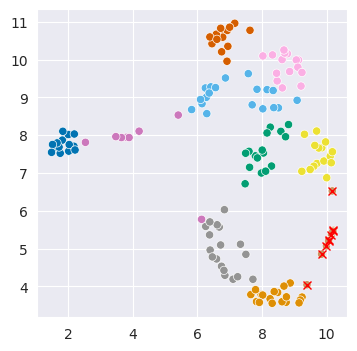

In [14]:
#===================================
# 3.2 Cluster the results using SpectralCustering
#===================================
predictor = cluster.SpectralClustering(random_state=42,
                                n_clusters=n_clusters, 
                                n_neighbors = n_neighbors,
                                affinity = 'nearest_neighbors', 
                                assign_labels='discretize')
clusteredHatA = predictor.fit_predict(hatA)

#===================================
# 3.3 Use UMAP embeddings
#===================================
transformer = umap.UMAP(random_state=65)
transformedHatA = transformer.fit_transform(hatA)

# highlighted cluster
targetCluster = 5

seaborn.set_style('darkgrid')
plt.figure(figsize=(4,4))
import pandas as pd
# data = pd.DataFrame(np.concatenate([r, c[...,None]],axis=1))

fig = seaborn.scatterplot(x=transformedHatA[:,0], y=transformedHatA[:,1], hue=clusteredHatA ,legend=False, palette='colorblind')
plt.plot(transformedHatA[:,0][clusteredHatA == targetCluster], transformedHatA[:,1][clusteredHatA == targetCluster], 'rx')


# plt.title("B", {'fontweight' : 'bold', 'verticalalignment': 'baseline', 'horizontalalignment': 'left'})
# plt.savefig(f"{target_path}/FigS83_post.eps", dpi=350)
# plt.savefig(f"{target_path}/FigS83_post.tif", dpi=350)
# plt.savefig(f"{target_path}/FigS83_post.png", dpi=350)

/home/jtfc/HS/M2aia/Sources/pym2aia-examples/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jtfc/HS/M2aia/Sources/pym2aia-examples/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jtfc/HS/M2aia/Sources/pym2aia-examples/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


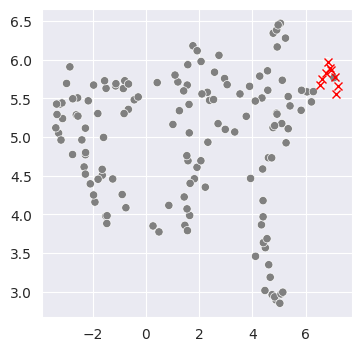

In [15]:
#===================================
# 2.3 Use UMAP embeddings
#===================================
# r_0 = t.transform(dt_0)
# c_0 = km_0.fit_predict(r_0)

seaborn.set_style('darkgrid')
plt.figure(figsize=(4,4))
d = seaborn.color_palette("light:grey", as_cmap=True)
markedClusters = clusteredHatA
markedClusters[markedClusters!=targetCluster] = 250
fig = seaborn.scatterplot(x=transformedA[:,0], y=transformedA[:,1], hue=markedClusters, legend=False, palette=d)
plt.plot(transformedA[:,0][clusteredHatA == targetCluster], transformedA[:,1][clusteredHatA == targetCluster], 'rx')
# plt.plot(r_0[:,0][c == 2], r_0[:,1][c == 2], 'or')
# plt.title("A", {'fontweight' : 'bold',
#  'verticalalignment': 'baseline',
#  'horizontalalignment': 'left'})
# plt.savefig(f"{target_path}/FigS81_pre.eps", dpi=350)
# plt.savefig(f"{target_path}/FigS81_pre.tif", dpi=350)
# plt.savefig(f"{target_path}/FigS81_pre.png", dpi=350)

/home/jtfc/HS/M2aia/Sources/pym2aia-examples/.venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


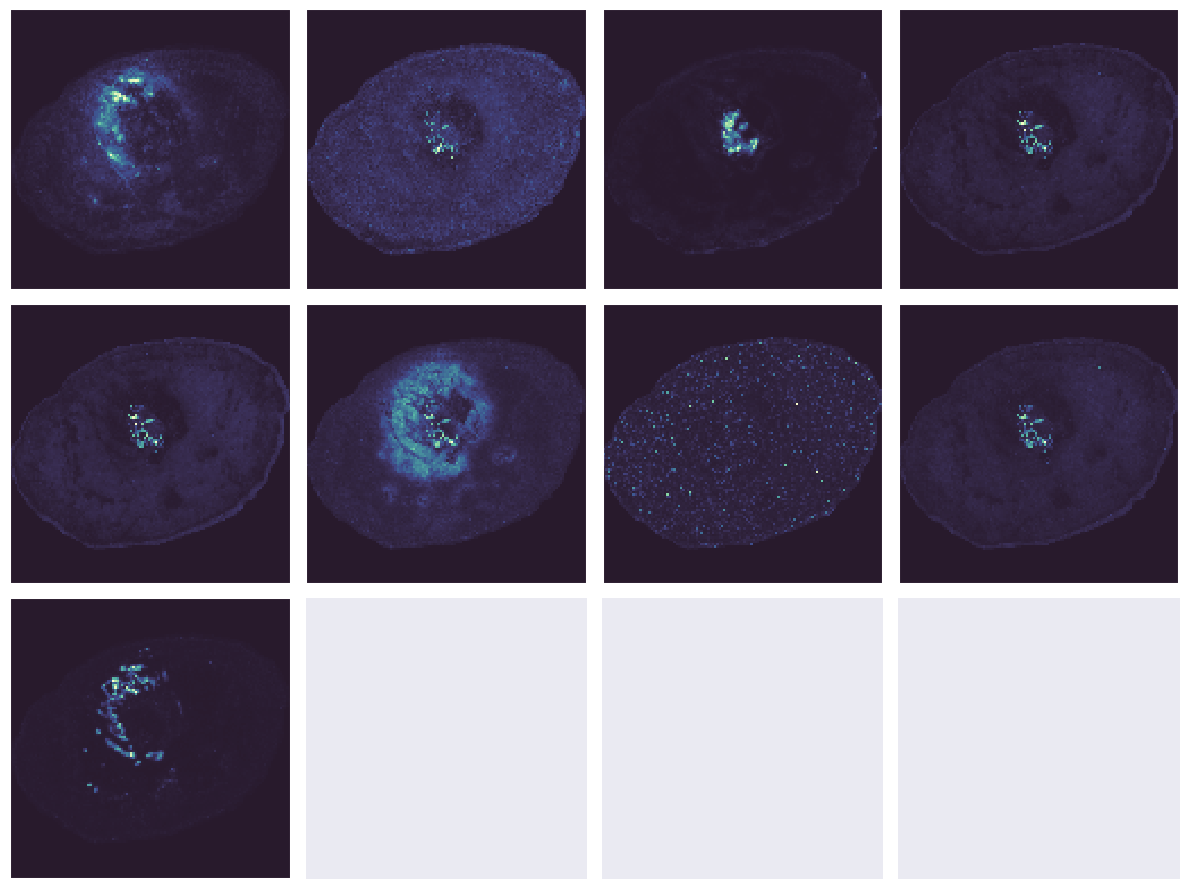

In [16]:
import seaborn_image as isns

ids = np.argwhere(clusteredHatA == targetCluster).flatten().tolist()
images=[]
for id in ids:
    images.append(dataset[id][0])

isns.ImageGrid(images, cbar=False, col_wrap=4)
# plt.savefig(f"{target_path}/FigS8Cluster.png", dpi=350)